In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from keras.layers import *
from keras.models import Model, load_model
from keras.datasets import mnist
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers
from keras import optimizers
from keras import backend as K
import scipy
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import pandas as pd
import numpy as np

In [ ]:
import tensorflow
tensorflow.compat.v1.disable_eager_execution()

# Why VAEs?

When using generative models, you could simply want to generate a random, new output, that looks similar to the training data, and you can certainly do that too with VAEs. But more often, you’d like to alter, or explore variations on data you already have, and not just in a random way either, but in a desired, specific direction. This is where VAEs work better than other method.

In the below example, we can see how the hypothetical embedding space for a standard autoencoder would look like

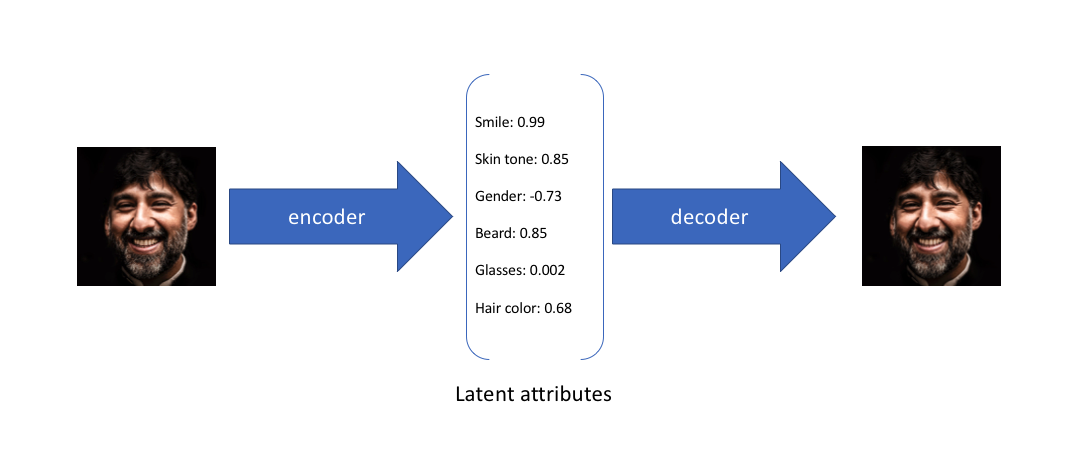



What if we wanted to generate new samples by modifying some attributes of a given sample as follows: 

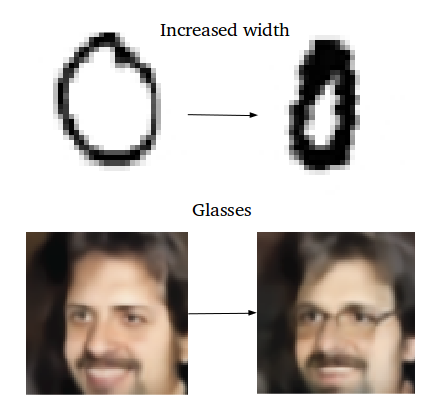

This is not possible with standard autoencoders since the embedding space is discrete as shown in the below figure:

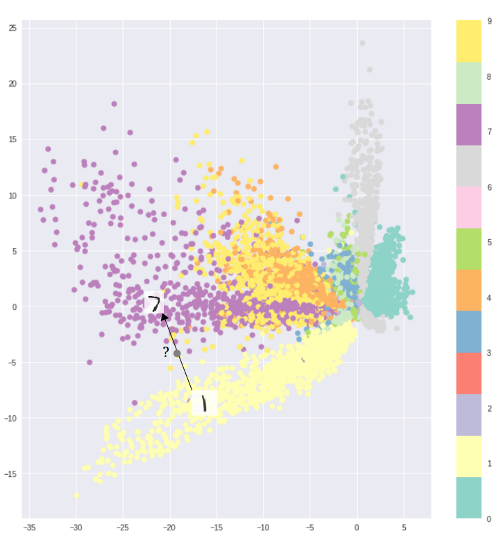

The fundamental problem with autoencoders, for generation, is that the latent space they convert their inputs to and where their encoded vectors lie, may not be continuous, or allow easy interpolation.

If the space has discontinuities (eg. gaps between clusters) and you sample/generate a variation from there, the decoder will simply generate an unrealistic output, because the decoder has no idea how to deal with that region of the latent space. During training, it never saw encoded vectors coming from that region of latent space.

This is where a variational autoencoder comes into the picture. Instead of using the encoder to predict a singular vector, we now predict a distribution (by predicting mean and std dev values for each of the units in the latent dimension). The decoder will now sample inputs from this distribution to decode. This makes the learned feature space continuous.

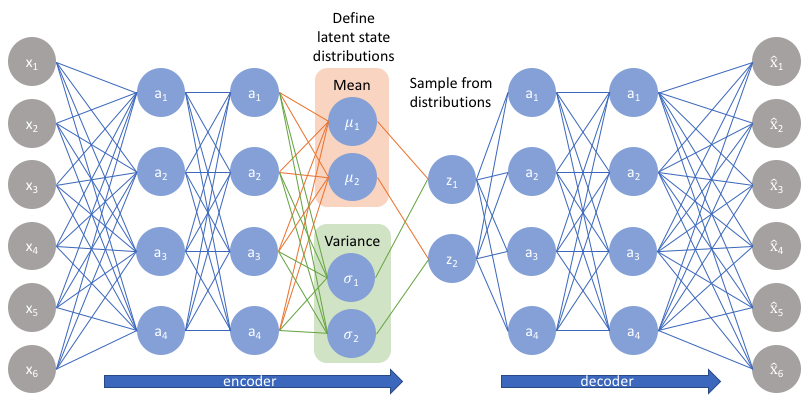

However, the question that now arises is that how to backpropogate while randomly sampling values through a distribution since gradients cannot be computed for random sampling. We overcome this issue using the reparameterization trick as shown below:

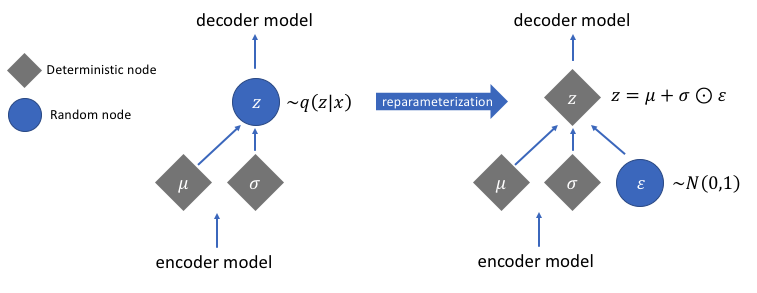

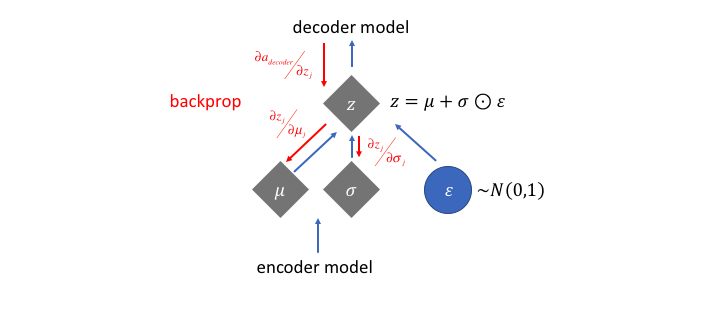

## Loss Function

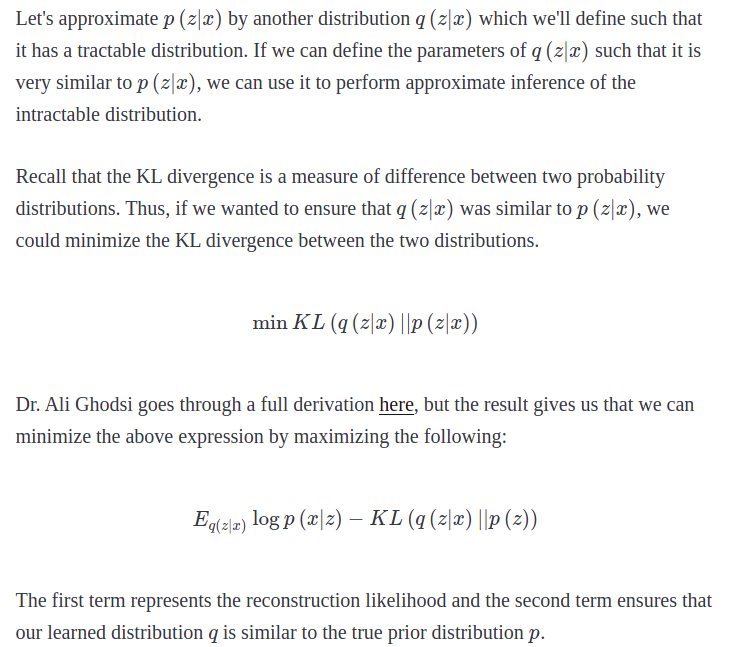

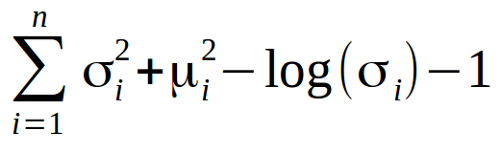

Link to derivation: https://youtu.be/uaaqyVS9-rM?t=19m42s

Finally, if we only use the standard reconstruction loss (MSE), the learned embedding spaces can be further away from each other thus reducing semantic meaning of generating new samples by modifying attributes.
This is why we use KL divergence. 

As we can see below, with the combination of reconstruction loss and KL divergence, the embedding spaces are both closer to each other and continuous. 

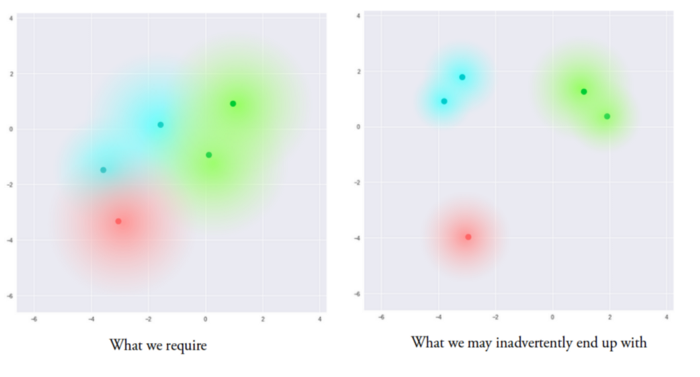

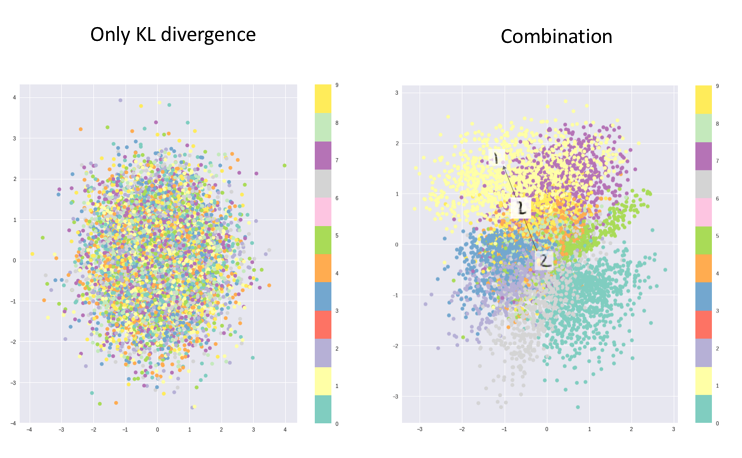

## Applications

Where to from here?
There are plenty of further improvements that can be made over the variational autoencoder. You could indeed, replace the standard fully-connected dense encoder-decoder with a convolutional-deconvolutional encoder-decoder pair, to produce great synthetic human face photos.

You could even train an autoencoder using LSTM encoder-decoder pairs (using a modified version of the seq2seq architecture) for sequential, discrete data (something not possible with methods such as GANs), to produce synthetic text, or even interpolate between MIDI samples such as Google Brain’s Magenta’s MusicVAE. Link: https://nips2017creativity.github.io/doc/Hierarchical_Variational_Autoencoders_for_Music.pdf



# Loading Dataset

In [ ]:
ls /usr/local/lib/python3.7/dist-packages/tensorflow/keras/datasets/


boston_housing/  cifar100/       imdb/        mnist/        reuters/
cifar10/         fashion_mnist/  __init__.py  __pycache__/


4423680/4422102 [==============================] - 0s 0us/step
Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


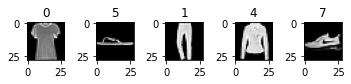

In [ ]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainy), (testX, testy) = fashion_mnist.load_data()
#for mnist Convo VAEs comment out the above line and uncomment the following line 
#(trainX, trainy), (testX, testy) = mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testy.shape))

for j in range(5):
    i = np.random.randint(0, 10000)
    plt.subplot(550 + 1 + j)
    plt.imshow(trainX[i], cmap='gray')
    plt.title(trainy[i])
plt.show()

# Data Preparation

In [ ]:
train_data = trainX.astype('float32')/255
test_data = testX.astype('float32')/255

train_data = np.reshape(train_data, (60000, 28, 28, 1))
test_data = np.reshape(test_data, (10000, 28, 28, 1))

print (train_data.shape, test_data.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


# VAE

## Encoder Part

In [ ]:
import tensorflow

#input_data = tensorflow.keras.layers.Input(shape=(784,))
#encoder = tensorflow.keras.layers.Dense(512, activation='relu')(input_data)
#encoder = tensorflow.keras.layers.Dense(16, activation='relu')(input_data)

# TODO: Homework
input_data = tensorflow.keras.layers.Input(shape=(28, 28, 1))
# Add Conv and MaxPool layers here
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_data)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
x = Conv2D(4, (2, 2), activation='relu', padding='same')(x)
x = Conv2D(1, (2, 2), activation='relu', padding='same')(x)

encoder = tensorflow.keras.layers.Flatten()(x)
encoder = tensorflow.keras.layers.Dense(2)(encoder)

## Latent Distribution and Sampling

In [ ]:
#reparameterization
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random

In [ ]:
distribution_mean = tensorflow.keras.layers.Dense(2, name='mean')(encoder)
distribution_variance = tensorflow.keras.layers.Dense(2, name='log_variance')(encoder)
latent_encoding = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])

In [ ]:
encoder_model = tensorflow.keras.Model(input_data, latent_encoding)
encoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 28, 28, 32)   320         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_8[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 32)   0           conv2d_9[0][0]                   
____________________________________________________________________________________________

## Decoder Part

In [ ]:
#as 2 hidden units
decoder_input = tensorflow.keras.layers.Input(shape=(2))

# Comment out the next 3 lines for homework
#decoder = tensorflow.keras.layers.Dense(16)(decoder_input)
#decoder = tensorflow.keras.layers.Dense(512)(decoder)
#decoder_output = tensorflow.keras.layers.Dense(784, activation='sigmoid')(decoder)

# TODO: Homework
decoder = tensorflow.keras.layers.Dense(4)(decoder_input)
decoder = tensorflow.keras.layers.Reshape((2, 2, 1))(decoder)

# Add conv transpose and upsampling2D layers after this: (Eg: decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder))
x = Conv2DTranspose(4, (2, 2), activation='relu', padding='same')(decoder)
x = Conv2DTranspose(16, (2, 2), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((7, 7))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

In [ ]:
decoder_model = tensorflow.keras.Model(decoder_input, decoded)
decoder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 12        
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 1)           0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 2, 2, 4)           20        
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 2, 2, 16)          272       
_________________________________________________________________
batch_normalization_2 (Batch (None, 2, 2, 16)          64        
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 16)        0     

## Combining

In [ ]:
encoded = encoder_model(input_data)
decoded = decoder_model(encoded)

In [ ]:
autoencoder = tensorflow.keras.models.Model(input_data, decoded)

In [ ]:
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_3 (Functional)         (None, 2)                 34901     
_________________________________________________________________
model (Functional)           (None, 28, 28, 1)         42417     
Total params: 77,318
Trainable params: 77,094
Non-trainable params: 224
_________________________________________________________________


## Loss Function (Reconstruction Loss + KL-loss)

In [ ]:
def get_loss(distribution_mean, distribution_variance):
    #simple loss crossentropy or mse or absolute sq mean etc(here mse is there)
    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tensorflow.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tensorflow.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*28*28
    #kl divergence loss
    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)
    
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch
    
    return total_loss

## Training

In [ ]:
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_3 (Functional)         (None, 2)                 34901     
_________________________________________________________________
model (Functional)           (None, 28, 28, 1)         42417     
Total params: 77,318
Trainable params: 77,094
Non-trainable params: 224
_________________________________________________________________


In [ ]:

train_data = train_data.reshape(-1, 28, 28, 1)
test_data = test_data.reshape(-1, 28, 28, 1)

In [ ]:
autoencoder.fit(train_data, train_data, epochs=20, batch_size=64, validation_data=(test_data, test_data))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 42s 706us/sample - loss: 37.5988 - val_loss: 32.0185
Epoch 2/20
60000/60000 [==============================] - 41s 676us/sample - loss: 30.3018 - val_loss: 31.4268
Epoch 3/20
60000/60000 [==============================] - 40s 673us/sample - loss: 29.0276 - val_loss: 28.8495
Epoch 4/20
60000/60000 [==============================] - 41s 676us/sample - loss: 28.4153 - val_loss: 28.7305
Epoch 5/20
60000/60000 [==============================] - 41s 675us/sample - loss: 27.8375 - val_loss: 27.4363
Epoch 6/20
60000/60000 [==============================] - 40s 672us/sample - loss: 27.5181 - val_loss: 27.4252
Epoch 7/20
60000/60000 [==============================] - 41s 678us/sample - loss: 27.2192 - val_loss: 26.8855
Epoch 8/20
60000/60000 [==============================] - 41s 677us/sample - loss: 26.9535 - val_loss: 27.2983
Epoch 9/20
60000/60000 [==============================] - 41s 

Real Test Images


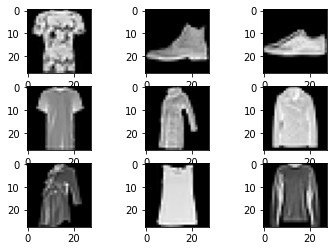

Reconstructed Images with Variational Autoencoder


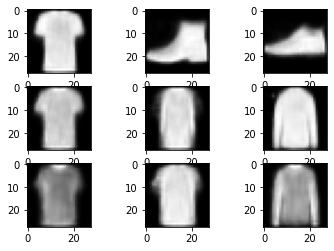

In [ ]:
offset=400
print ("Real Test Images")
# Real Images
for i in range(9):
    plt.subplot(330 + 1 + i)
    # plt.imshow(test_data[i+offset,:,:, -1], cmap='gray')
    reshaped_img = np.reshape(test_data[i+offset,:], (28, 28))
    plt.imshow(reshaped_img,  cmap='gray')
plt.show()

# Reconstructed Images as we didnt use convo layers the result is worthless
print ("Reconstructed Images with Variational Autoencoder")
for i in range(9):
    plt.subplot(330 + 1 + i)
    output = autoencoder.predict(np.array([test_data[i+offset]]))
    op_image = np.reshape(output[0]*255, (28, 28))
    plt.imshow(op_image, cmap='gray')
plt.show()

For convolutional VAEs, output will look something like this: 


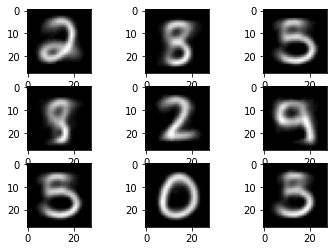

## Latent feature clusters

In [ ]:
x = []
y = []
z = []
for i in range(10000):
    z.append(testy[i])
    op = encoder_model.predict(np.array([test_data[i]]))
    x.append(op[0][0])
    y.append(op[0][1])

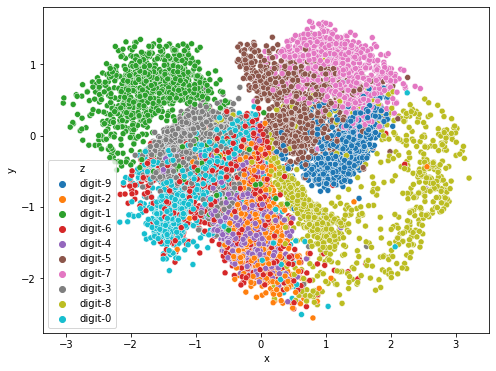

In [ ]:
df = pd.DataFrame()
df['x'] = x
df['y'] = y
df['z'] = ["digit-"+str(k) for k in z]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='x', y='y', hue='z', data=df)
plt.show()
#embbeding space or latent space plot

## Image Generation

In [ ]:
generator_model = decoder_model

In [ ]:
x_values = np.linspace(-3, 3, 30)
y_values = np.linspace(-3, 3, 30)

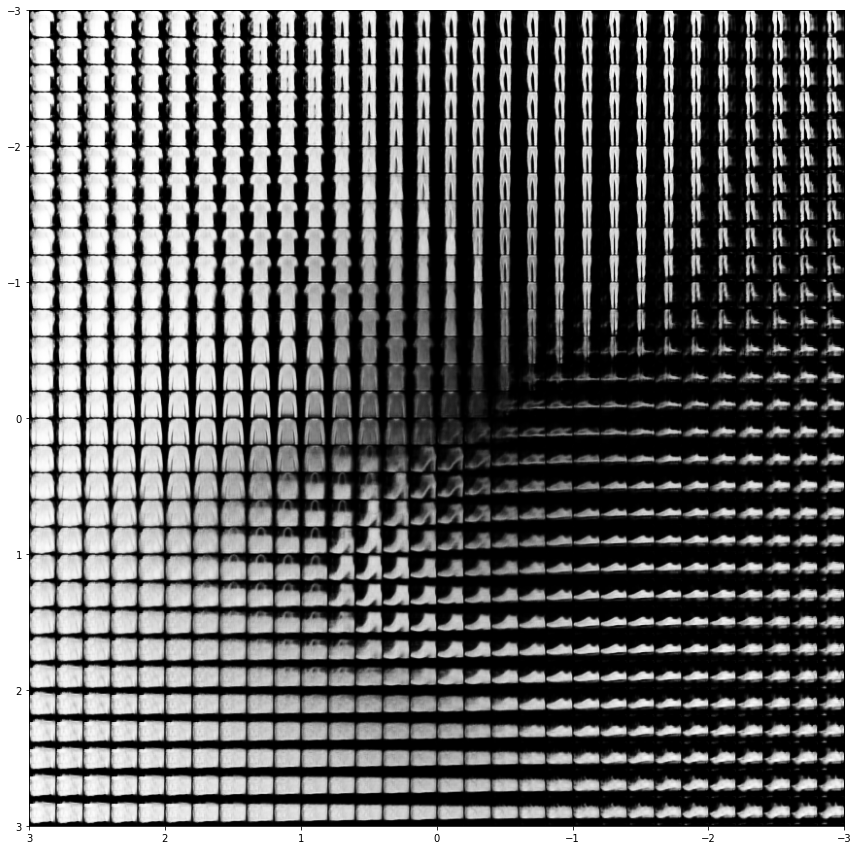

In [ ]:
figure = np.zeros((28 * 30, 28 * 30))
for ix, x in enumerate(x_values):
    for iy, y in enumerate(y_values):
        latent_point = np.array([[x, y]])
        generated_image = generator_model.predict(latent_point)[0]
        reshaped_img = np.reshape(generated_image, (28, 28))
        # figure[ix*28:(ix+1)*28, iy*28:(iy+1)*28,] = generated_image[:,:,-1]
        figure[ix*28:(ix+1)*28, iy*28:(iy+1)*28,] = reshaped_img
 
plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='gray', extent=[3,-3,3,-3])
plt.show()



For convolutional VAEs, output will look something like this:
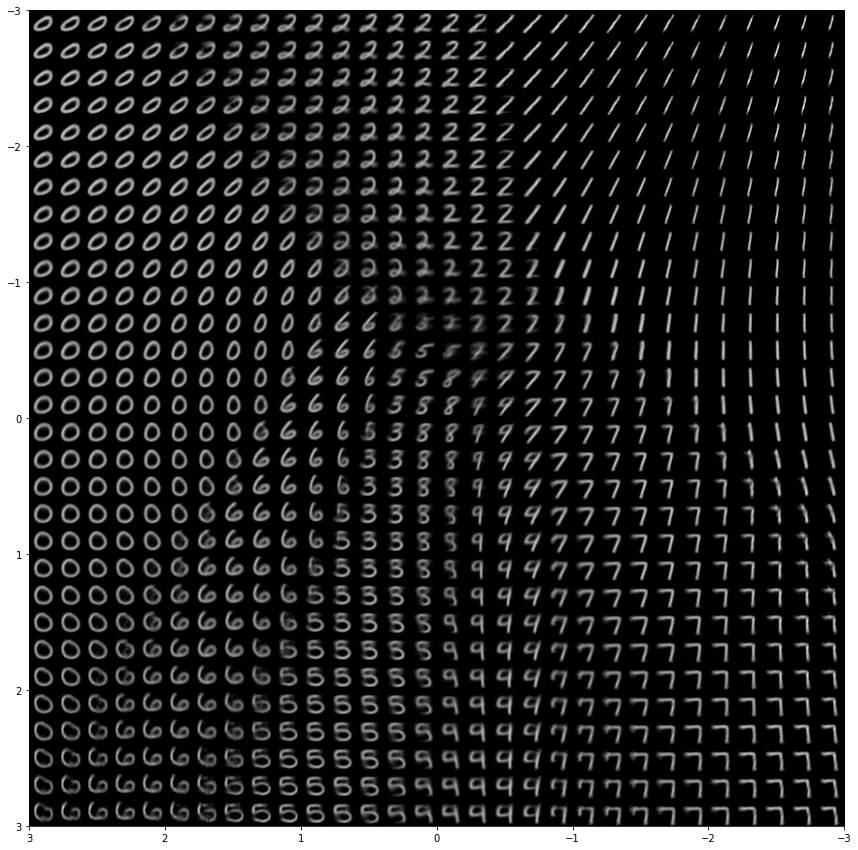

# Homework

Train a variational autoencoder on the Mnist and Fashion-Mnist datasets using a convolutional autoencoders instead of just dense layers and generate the latent embedding space and generated visualizations as shown in the above figures.


Ref: https://towardsdatascience.com/variational-autoencoders-as-generative-models-with-keras-e0c79415a7eb

References:

1. https://www.jeremyjordan.me/variational-autoencoders/
2. https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf
3. https://towardsdatascience.com/variational-autoencoders-as-generative-models-with-keras-e0c79415a7eb
